## Data Preparation and data Augmentation

Not **all** data could be loaded at one time into the memory.

***protobuf (二进制数据)***

**TFRecords** is a type of binary file, which doesn't need separated label files, and could better utilize the memory. 在tensorflow中快速的复制，移动，读取，存储等。

TFRecords could be used as following steps:

1. create TFRecords files based on the original data.
 - Define the Examples，and define the data type;
 - Then pickle/serialize the data as string（序列化）
 - save the pickled string into TFRecords
2. decode TFRecords files。
3. call the TFRecords files while training

protobuf looks like this：

```proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3; // kind of the same as an array
}

```

In [0]:
!pip install pillow # img processing package
!pip install tqdm # check the process of the program
!pip install glob # very powerful, could be used with regex, package all the path of the files

  ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [0]:
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import sys
import glob
import tensorflow as tf
cwd = os.path.join(os.getcwd(),'mnist','train')

In [0]:
image_list = glob.glob(os.path.join(cwd,'0')+'/*.png') # package all the png files names under the [0] folder into this list
label_list = np.zeros(len(image_list))

In [0]:
#图像标签生成tfrecord函数
def image2tfrecord(image_list,label_list,filename):
    '''
    image_list:image path list
    label_list:label list
    '''
    length=len(image_list)
    writer=tf.python_io.TFRecordWriter(filename)
    for i in range(length):
        if i % 100==0:
            ratio=round(i/float(length),4)
            sys.stdout.write('ratio:{}\r'.format(ratio))
            sys.stdout.flush()
        image=Image.open(image_list[i])# load every image
        # then check the image type; if it is png file, could cause problem:
        # the image could be RGB or Gray or other files.
        
        if 'png' in image_list[i][-4:]:
            if image.mode=='RGB':
                r, g, b = image.split()
                image = Image.merge("RGB", (r, g, b))
            elif image.mode=='L': # gray image
                pass
            else: # could be 带透明通道的 image
              # a 就是透明通道
              # get rid of channel a 
                r,g, b, a = image.split()
                image = Image.merge("RGB", (r, g, b))
        image=image.resize((28,28))
        #这个地方就展开了
        image_bytes=image.tobytes() #make the image to a binary image
        features={}
        features['image']=tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes]))
        features['label']=tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label_list[i])]))
        tf_features=tf.train.Features(feature=features)
        tf_example=tf.train.Example(features=tf_features)
        tf_serialized=tf_example.SerializeToString()
        writer.write(tf_serialized)
    writer.close()

In [0]:
image2tfrecord(image_list,label_list,'train0.tfrecords')

In [0]:
cwd

'/Users/wanjun/Desktop/深度之眼/编程/mnist/train'

In [0]:
# 生成10个tfrecords
for i in range(10):
    print('=====')
    print(i)
    image_list = glob.glob(os.path.join(cwd,'{}'.format(i))+'/*.png') 
    label_list = np.zeros(len(image_list))+i
    image2tfrecord(image_list,label_list,'train_{}.tfrecords'.format(i))

=====
0
=====:0.9961
1
=====:0.9938
2
=====:0.9903
3
=====:0.9949
4
=====:0.9928
5
=====:0.9961
6
=====:0.9971
7
=====:0.9896
8
=====:0.9913
9


In [0]:
# decoding function 
def parse_tf(example_proto):
    dics={}
    dics['label']=tf.FixedLenFeature((),dtype=tf.int64,default_value=0) 
    dics['image']=tf.FixedLenFeature((),dtype=tf.string,default_value="") 

    parsed_example=tf.parse_single_example(serialized=example_proto,features=dics)
    image=tf.decode_raw(parsed_example['image'],out_type=tf.uint8) 
    #image=tf.image.decode_jpeg(parsed_example['image'], channels=1)
    #这个地方可以加一些操作
    image=pre_process(image) # data preprocessing  --> augmentation
    image=tf.cast(image,tf.float32)/255 # normalization to [-1,1]
    image=tf.reshape(image,(28,28,1))
    
    
    #标签的操作
    label=parsed_example['label']
    label=tf.cast(label,tf.int32)
    label = tf.one_hot(label,depth=10,on_value=1.0,off_value=0.0) # 10 classification 
    return image,label

In [0]:
#dataset
# used for data preparation
def dataset(filenames,batch_size,epochs):
    dataset=tf.data.TFRecordDataset(filenames=filenames) #params is my tfrecord file path
    new_dataset=dataset.map(parse_tf)
    shuffle_dataset=new_dataset.shuffle(buffer_size=(100000)) # buffer size tells us how much data we want to randomly choose
    batch_dataset=shuffle_dataset.batch(batch_size).repeat(epochs)
    batch_dataset=batch_dataset.prefetch(1)
    iterator=batch_dataset.make_one_shot_iterator()
    next_element=iterator.get_next()
    return next_element

### Prefetch 

![](https://raw.githubusercontent.com/ffflora/data-science-notes/master/archived-pics/open-course/prefetch.png)

In [0]:
# data preprocessing 
# data augmentation

def pre_process(images,random_flip_up_down=False,random_flip_left_right=False,random_brightness=True,random_contrast=True,random_saturation=False,random_hue=False):
    if random_flip_up_down:
        images = tf.image.random_flip_up_down(images)
    if random_flip_left_right:
        images = tf.image.random_flip_left_right(images)
    if random_brightness:
        images = tf.image.random_brightness(images, max_delta=0.2)
    if random_contrast:
        images = tf.image.random_contrast(images, 0.9, 1.1)
    if random_saturation:
        images = tf.image.random_saturation(images, 0.3, 0.5)
    if random_hue:
        images = tf.image.random_hue(images,0.2)
    new_size = tf.constant([28,28],dtype=tf.int32)
    images = tf.image.resize_images(images, new_size)
    return images

In [0]:
tf.reset_default_graph()
filenames=['train0.tfrecords']
next_element=dataset(filenames,batch_size=5,epochs=1)
init = tf.global_variables_initializer()

In [0]:
with tf.Session() as sess:
    sess.run(init)
    batch_images,batch_labels=sess.run([next_element[0],next_element[1]]) # one for image, one for lable
    for i in range(batch_images.shape[0]):
        print(batch_images[i].shape)
        img = np.array(batch_images[i])

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


---

### 二、 使用生成器的方法读取数据训练神经网络


In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import sys


tf.reset_default_graph()
epochs = 15
batch_size = 100
total_sum = 0
epoch = 0
filenames=['train_{}.tfrecords'.format(i) for i in range(10)] # create a list that contains all the file path
next_element=dataset(filenames,batch_size=batch_size,epochs=epochs)

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
train_num = mnist.train.num_examples



input_data = tf.placeholder(tf.float32,shape=(None,784))
input_label = tf.placeholder(tf.float32,shape=(None,10))

w1 = tf.get_variable(shape=(784,64),name='hidden_1_w')
b1 = tf.get_variable(shape=(64),initializer=tf.zeros_initializer(),name='hidden_1_b')

w2 = tf.get_variable(shape=(64,32),name='hidden_2_w')
b2 = tf.get_variable(shape=(32),initializer=tf.zeros_initializer(),name='hidden_2_b')

w3 = tf.get_variable(shape=(32,10),name='layer_output')

#logit层
output = tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(input_data,w1)+b1),w2)+b2),w3)

loss = tf.losses.softmax_cross_entropy(input_label,output)

#opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
opt = tf.train.AdamOptimizer()

train_op = opt.minimize(loss)

# 测试评估
correct_pred = tf.equal(tf.argmax(input_label,axis=1),tf.argmax(output,axis=1))
acc = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

tf.add_to_collection('my_op',input_data)
tf.add_to_collection('my_op',output)
tf.add_to_collection('my_op',loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run([init])
    test_data = mnist.test.images
    test_label = mnist.test.labels
    while epoch<epochs:
        data,label=sess.run([next_element[0],next_element[1]])
        data = data.reshape(-1,784)
        total_sum+=batch_size
        sess.run([train_op],feed_dict={input_data:data,input_label:label})
        if total_sum//train_num>epoch:
            epoch = total_sum//train_num
            loss_val = sess.run([loss],feed_dict={input_data:data,input_label:label})
            acc_test = sess.run([acc],feed_dict={input_data:test_data,input_label:test_label})
            saver.save(sess, save_path="./model/my_model.ckpt")
            print('epoch:{},train_loss:{:.4f},test_acc:{:.4f}'.format(epoch,loss_val[0],acc_test[0]))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
epoch:1,train_loss:0.1908,test_acc:0.9375
epoch:2,train_loss:0.1843,test_acc:0.9551
epoch:3,train_loss:0.1266,test_acc:0.9607
epoch:4,train_loss:0.1294,test_acc:0.9622
epoch:5,train

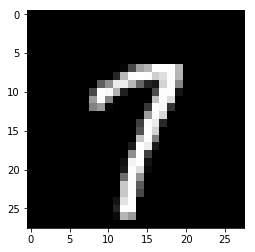

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
index = 666
plt.imshow(test_data[index].reshape(28,28),cmap='gray')

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph('./model/my_model.ckpt.meta')
saver.restore(sess,"./model/my_model.ckpt")
input_tensor = tf.get_collection('my_op')[0]
output_tensor = tf.get_collection('my_op')[1]

INFO:tensorflow:Restoring parameters from ./model/my_model.ckpt


---
### 三、 Tensorflow和Keras的混合使用

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import sys


tf.reset_default_graph()
epochs = 15
batch_size = 100
total_sum = 0
epoch = 0
filenames=['train_{}.tfrecords'.format(i) for i in range(10)]
next_element=dataset(filenames,batch_size=batch_size,epochs=epochs)

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
train_num = mnist.train.num_examples

input_data = tf.placeholder(tf.float32,shape=(None,28,28,1))
input_label = tf.placeholder(tf.float32,shape=(None,10))

hidden1 = tf.keras.layers.Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu')(input_data)

hidden2 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding='same',activation='relu')(hidden1)

hidden3 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=2,padding='valid',activation='relu')(hidden2)

hidden4 = tf.keras.layers.MaxPool2D(pool_size=2)(hidden3)

hidden5 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,strides=2,padding='valid',activation='relu')(hidden4)

hidden5 = tf.layers.Flatten()(hidden5)

output = tf.keras.layers.Dense(10,activation='softmax')(hidden5)

#损失函数
loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(input_label,output))

#优化器
opt = tf.train.AdamOptimizer()
train_op = opt.minimize(loss)

# 测试评估
acc = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(input_label,output))
#correct_pred = tf.equal(tf.argmax(input_label,axis=1),tf.argmax(output,axis=1))
#acc = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

tf.add_to_collection('my_op',input_data)
tf.add_to_collection('my_op',output)
tf.add_to_collection('my_op',loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run([init])
    test_data = mnist.test.images
    test_label = mnist.test.labels
    test_data = test_data.reshape(-1,28,28,1)
    while epoch<epochs:
        data,label=sess.run([next_element[0],next_element[1]])
        total_sum+=batch_size
        sess.run([train_op],feed_dict={input_data:data,input_label:label})
        if total_sum//train_num>epoch:
            epoch = total_sum//train_num
            loss_val = sess.run([loss],feed_dict={input_data:data,input_label:label})
            acc_test = sess.run([acc],feed_dict={input_data:test_data,input_label:test_label})
            saver.save(sess, save_path="./model/my_model.ckpt")
            print('epoch:{},train_loss:{:.4f},test_acc:{:.4f}'.format(epoch,loss_val[0],acc_test[0]))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
epoch:1,train_loss:0.0848,test_acc:0.9731
epoch:2,train_loss:0.0854,test_acc:0.9833
epoch:3,train_loss:0.0118,test_acc:0.9840
epoch:4,train_loss:0.0443,test_acc:0.9830
epoch:5,train_loss:0.0137,test_acc:0.9853
epoch:6,train_loss:0.0154,test_acc:0.9876
epoch:7,train_loss:0.0015,test_acc:0.9875
epoch:8,train_loss:0.0066,test_acc:0.9867
epoch:9,train_loss:0.0019,test_acc:0.9906
epoch:10,train_loss:0.0048,test_acc:0.9890
epoch:11,train_loss:0.0003,test_acc:0.9897
epoch:12,train_loss:0.0007,test_acc:0.9890
epoch:13,train_loss:0.0037,test_acc:0.9894
epoch:14,train_loss:0.0017,test_acc:0.9882
epoch:15,train_loss:0.0006,test_acc:0.9870
